In [1]:
%matplotlib inline

import random
import numpy as np
from scipy.misc import imread, imresize
import tensorflow as tf
import matplotlib.pyplot as plt
from vgg16 import vgg16 
from PIL import Image
import keras


Using TensorFlow backend.


### Transfer Learning
  - 이미 다른 dataset으로 training되어 있는 네트워크를 이용해 다른 Task를 할 수 있도록 Training 시키는 것
  - 초기부터 training하는 것보다 성능이 좋다.

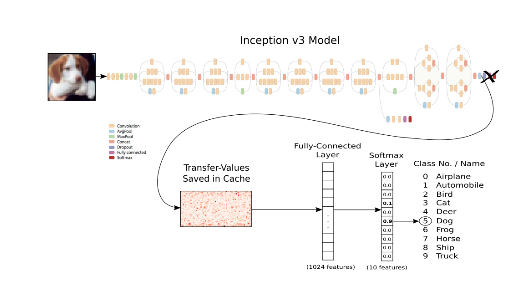

In [2]:
img = Image.open("../resource/08_transfer_learning_flowchart.png")
plt.imshow(img)
plt.axis("off"); plt.show()

### CIFAR-10 Dataset
  - 10개의 class를 가진 image dataset
  - Training set: 50000개, Testing set: 10000개
  - https://www.cs.toronto.edu/~kriz/cifar.html
  - Images
    - size: (32, 32, 3)
  - Labels
    - size: one-hot vector (1, 10)

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
class_names = ['airplane',  'automobile',  'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
        
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

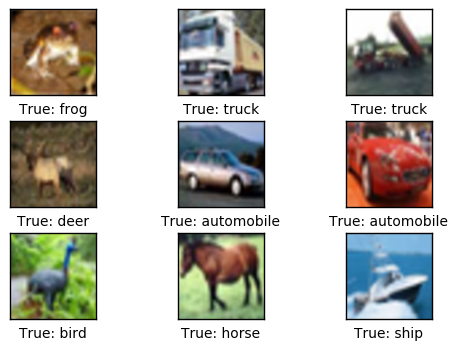

In [5]:
plot_images(x_train[0:9], y_train[0:9].reshape(9))

#### Dataset Augmentation

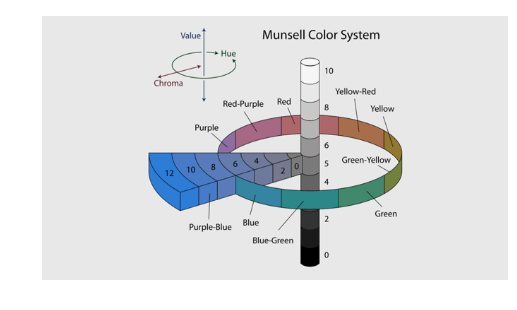

In [6]:
img = Image.open("../resource/munsell-color-system.png")
plt.imshow(img)
plt.axis("off"); plt.show()

In [7]:
def pre_process_image(image, training):
    if training:
        # 이미지를 랜덤으로 좌우 반전.
        image = tf.image.random_flip_left_right(image)
        
        # 이미지의 명도, 채도 등을 랜덤으로 변경
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        
        # 혹시 변경하는 중에 값이 초과하지 않았는지 확인
        image = tf.minimum(image, 255.0)
        image = tf.maximum(image, 0.0)
        
    image = tf.image.resize_images(image, [224, 224])

    return image

In [8]:
def pre_process(images, training):
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images
def to_array(image):
    with tf.Session():
        arr = image.eval()
        return arr
def to_arrays(images):
    arrs = tf.map_fn(lambda image: to_array(image), images)
    return arrs

#### Training 

In [9]:
# 변수 설정
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [10]:
distorted_images = pre_process(images=x, training=True)

In [11]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = tf.Session().run(distorted_images, feed_dict=feed_dict)
    
    result = np.array(result, dtype=np.uint8)
    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

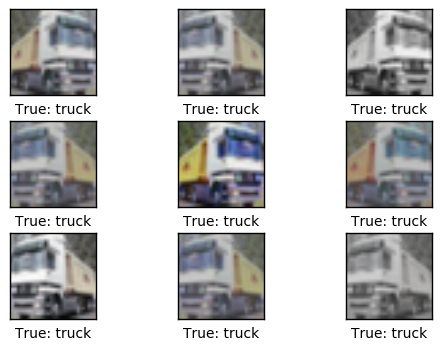

In [12]:
plot_distorted_image(x_train[1], y_train[1])

In [13]:
# Pretraine 된 모델 불러오기
sess = tf.Session()
vgg = vgg16(distorted_images, 'vgg16_weights.npz', sess)

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)
26 fc6_W (25088, 4096)
27 fc6_b (4096,)
28 fc7_W (4096, 4096)
29 fc7_b (4096,)
30 fc8_W (4096, 1000)
31 fc8_b (1000,)


In [14]:
# class가 10개이므로 10-dim 으로 바꾸기 위해 Linear layer(fc layer)를 하나 추가한다.

fc8_W = tf.Variable(tf.truncated_normal([1000, 10], dtype=tf.float32, stddev=0.01), name='fc3_weights')
fc8_B = tf.Variable(tf.truncated_normal([10], dtype=tf.float32, stddev=0.01), trainable=True, name='biases')
fc4 = tf.nn.bias_add(tf.matmul(vgg.fc3l, fc8_W), fc8_B)
prob = tf.nn.softmax(fc4)

# MNIST와 같이 cross_entropy loss 사용

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(prob), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.005).minimize(cross_entropy)

In [15]:
""" 정확도 정의
  정확도 = 맞춘 데이터 수 / 전체 데이터 수
"""
# 예측한 레이블과 실제 레이블이 같은 데이터의 수를 계산
correct_prediction = tf.equal(tf.argmax(prob,1), y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [16]:
# Label을 one-hot vector로 바꾸어주는 함수 
def makeLabel(y):
    result = np.zeros((y.shape[0], 10))
    cnt = 0
    for i in y:
        result[cnt, i] = 1.
        cnt += 1
    return result

# Batch를 가져오는 파트를 직접 구현해야 함. 
def get_batch(batch_size, iteration, train=True):
    # Batch_size만큼 image와 label one-hot vector를 만들어 리턴한다.
    if not train:
        if batch_size*(iteration+1)-1 < len(x_test):
            batch_x = x_test[(batch_size*iteration):(batch_size*(iteration+1))]
            batch_y = makeLabel(y_test[(batch_size*iteration):(batch_size*(iteration+1))])
        else:
            batch_x = x_test[(batch_size*iteration):len(x_test)]
            batch_y = makeLabel(y_test[(batch_size*iteration):len(x_test)])
    if batch_size*(iteration+1)-1 < len(x_train):
        batch_x = x_train[(batch_size*iteration):(batch_size*(iteration+1))]
        batch_y = makeLabel(y_train[(batch_size*iteration):(batch_size*(iteration+1))])
    else:
        batch_x = x_train[(batch_size*iteration):len(x_train)]
        batch_y = makeLabel(y_train[(batch_size*iteration):len(x_train)])
    return (batch_x, batch_y)


In [17]:
batch_size = 96
total_batch = int(len(x_train)/batch_size)
init = tf.variables_initializer([fc8_W, fc8_B])

sess.run(init)

# epoch: training 데이터 전체를 다 보는 경우를 의미
# 아래의 경우 1 epoch 동안 모델을 학습함
for epoch in range(1):
    total_cost = 0

    # iteration (i): 하나의 batch를 보는 경우를 의미
    for i in range(total_batch):
        # batch 데이터를 가져옴
        batch_xs, batch_ys = get_batch(batch_size, i)
        # 모델 업데이트 수행
        # sess.run(수행하고자 하는 연산, 연산을 수행하기 위해 요구되는 placeholder를 제공)
        _, cost_val = sess.run([train_step, cross_entropy], \
                                feed_dict={x: batch_xs, y_true: batch_ys})
        
        total_cost += cost_val
        if i % 50 == 0:
            print "Iter: ", "%d/%d" % (i, total_batch), \
                  "Avg. cost=", '{:.3f}'.format(total_cost / (i+1))
        
    print "Epoch:", "%02d" % (epoch + 1), \
        "Avg. cost =", '{:.3f}'.format(total_cost / total_batch)

# 테스트 데이터에 대한 정확도
total_batch_test = int(len(x_test)/batch_size)
total_acc = 0
for i in range(total_batch_test):
    batch_xs, batch_ys = get_batch(batch_size, i)
    
    acc = sess.run(accuracy, feed_dict={x: batch_xs, y_true: batch_ys})
    total_acc += acc
    
print "Test Accuracy: ", total_acc / total_batch_test

Iter:  0/520 Avg. cost= 2.391
Iter:  50/520 Avg. cost= 1.322
Iter:  100/520 Avg. cost= 0.977
Iter:  150/520 Avg. cost= 0.825
Iter:  200/520 Avg. cost= 0.744
Iter:  250/520 Avg. cost= 0.683
Iter:  300/520 Avg. cost= 0.633
Iter:  350/520 Avg. cost= 0.596
Iter:  400/520 Avg. cost= 0.563
Iter:  450/520 Avg. cost= 0.538
Iter:  500/520 Avg. cost= 0.515
Epoch: 01 Avg. cost = 0.508
Test Accuracy:  0.911057725549


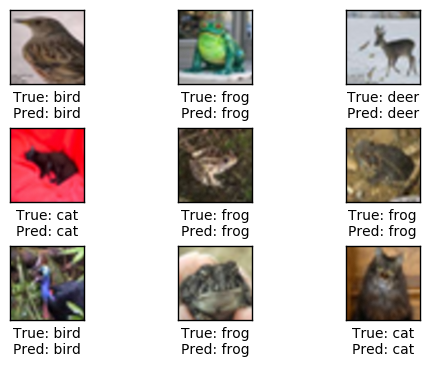

In [26]:
batch_xs, batch_ys = get_batch(9, 2)
prob_val = sess.run(prob, feed_dict={x: batch_xs, y_true: batch_ys})
plot_images(batch_xs, np.argmax(batch_ys, 1), cls_pred=np.argmax(prob_val, 1), smooth=True)